In [1]:
!pip install disarray

In [2]:
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools
import disarray

In [3]:
def count_jpg_files(root_dir):
    """
    Count all .jpg files in the given directory and its subdirectories
    
    Args:
        root_dir (str): Path to the root directory to start searching from
        
    Returns:
        int: total count
    """
    total_count = 0
    dir_counts = {}
    
    # Walk through all directories
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Count jpg files in current directory
        jpg_count = len([f for f in filenames if f.lower().endswith('.jpg')])
        total_count += jpg_count
    
    return total_count

In [4]:
train_path = '/kaggle/input/multiclasssegnetsegmentedimages/segnet_segmented/train_directory'
validation_path = '/kaggle/input/multiclasssegnetsegmentedimages/segnet_segmented/validation_directory'
test_path = '/kaggle/input/multiclasssegnetsegmentedimages/segnet_segmented/test_directory'

In [5]:
preprocess_input = tensorflow.keras.applications.mobilenet_v2.preprocess_input

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
batch_size = 64
train_image_gen = image_gen.flow_from_directory(train_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical')

val_image_gen = image_gen.flow_from_directory(validation_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

test_image_gen = image_gen.flow_from_directory(test_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

print(test_image_gen.class_indices)

Found 36927 images belonging to 7 classes.
Found 883 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [7]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [9]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_score_value = 2*((precision_value*recall_value)/(precision_value+recall_value+K.epsilon()))
    return f1_score_value

In [10]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy, precision, recall, f1_score])

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.5,
    patience=3,        
    mode='max',
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,       
    mode='min',
    restore_best_weights=True,
    verbose=1
)

model_chkpt = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose=1
)

callback_list = [model_chkpt, lr_reduce, early_stop]

In [12]:
total_samples = sum([5115, 5950, 5990, 5462, 5510, 4810, 4090])
class_weights = {
    0: total_samples / 5510,
    1: total_samples / 5462,
    2: total_samples / 5990,
    3: total_samples / 4090,
    4: total_samples / 5950,
    5: total_samples / 5115,
    6: total_samples / 4810
}

In [13]:
history = tl_model.fit(train_image_gen,
                       epochs=30, 
                       validation_data = val_image_gen,
                       class_weight=class_weights,
                       callbacks=callback_list)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - categorical_accuracy: 0.4891 - f1_score: 0.4127 - loss: 11.5511 - precision: 0.6606 - recall: 0.3107 - top_2_accuracy: 0.6815 - top_3_accuracy: 0.8023
Epoch 1: val_categorical_accuracy improved from -inf to 0.80521, saving model to best_model.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 386s 582ms/step - categorical_accuracy: 0.4893 - f1_score: 0.4129 - loss: 11.5481 - precision: 0.6607 - recall: 0.3109 - top_2_accuracy: 0.6817 - top_3_accuracy: 0.8024 - val_categorical_accuracy: 0.8052 - val_f1_score: 0.8096 - val_loss: 2.8198 - val_precision: 0.8239 - val_recall: 0.7971 - val_top_2_accuracy: 0.9026 - val_top_3_accuracy: 0.9388 - learning_rate: 1.0000e-04
Epoch 2/30
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - categorical_accuracy: 0.7071 - f1_score: 0.6861 - loss: 7.2086 - precision: 0.7896 - recall: 0.6080 - top_2_accuracy: 0.8830 - top_3_accuracy: 0.9532
Epoch 2: val_categorical_accuracy improved from 0.80521 to 0.84145, saving model to best_model

In [14]:
tl_model.save('val_loss_epoch.keras')

<Axes: >

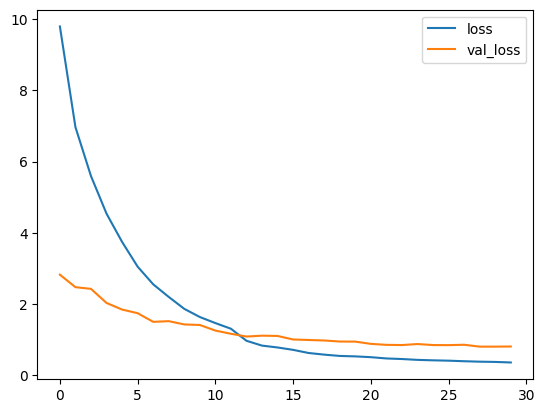

In [15]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

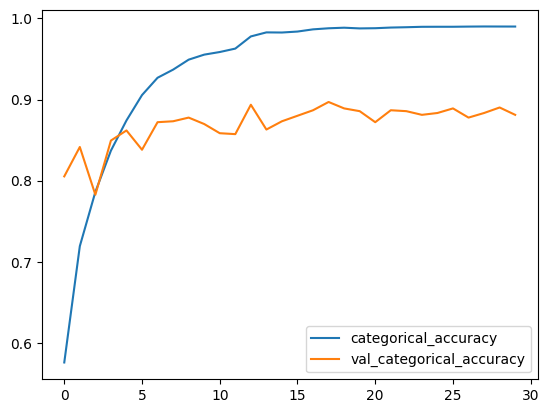

In [16]:
metrics[["categorical_accuracy","val_categorical_accuracy"]].plot()

<Figure size 640x480 with 0 Axes>

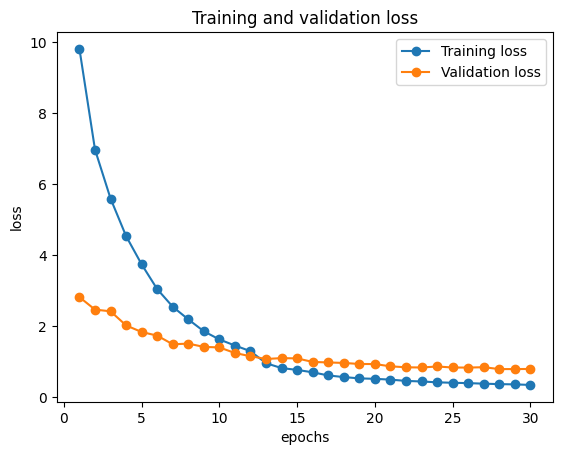

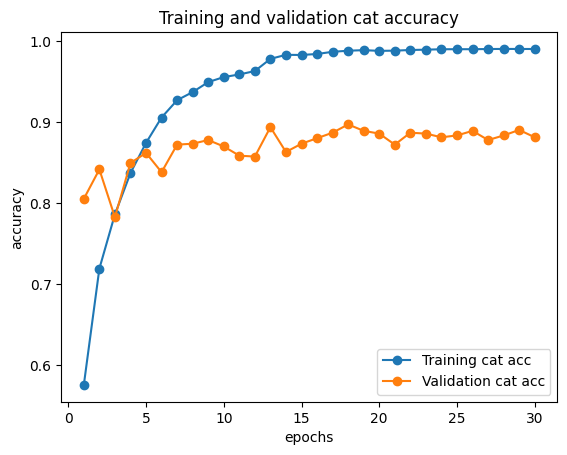

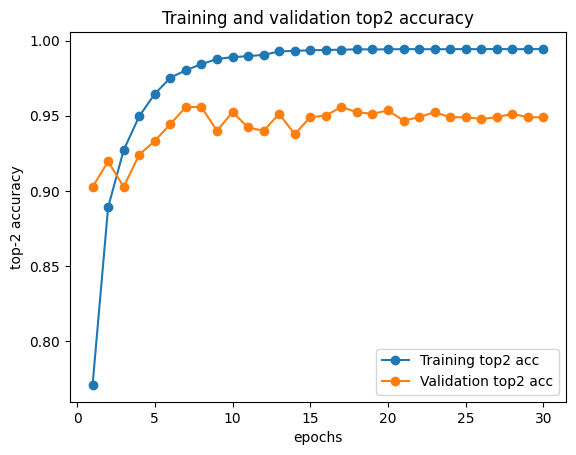

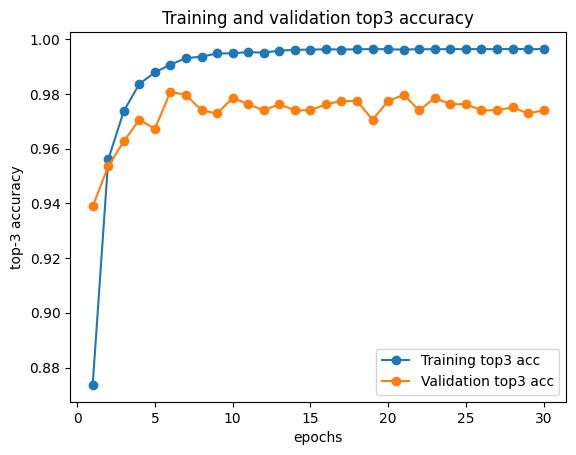

<Figure size 640x480 with 0 Axes>

In [17]:
# display the accuracy, top-2 accuracy and top-3 accuracy

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "-o", label='Training loss')
plt.plot(epochs, val_loss, "-o", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
# plt.figure()
plt.savefig('loss.png', dpi=300)
plt.figure()

plt.plot(epochs, acc, "-o", label='Training cat acc')
plt.plot(epochs, val_acc, "-o", label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
# plt.figure()
plt.savefig('acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top2_acc, "-o", label='Training top2 acc')
plt.plot(epochs, val_top2_acc, "-o", label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-2 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top2acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top3_acc, "-o", label='Training top3 acc')
plt.plot(epochs, val_top3_acc, "-o", label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-3 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top3acc.png', dpi=300)
plt.figure()

In [18]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc_curves_from_generator(predictions, test_labels, class_names):
    """
    Plot ROC curves for predictions from a generator-based model.
    
    Parameters:
    predictions: Raw predictions from model.predict()
    test_labels: True labels from generator.classes
    class_names: List of class names in order matching generator.class_indices
    """
    # Convert predictions to probabilities if not already
    if len(predictions.shape) == 1:  # If predictions are already argmaxed
        # Convert to one-hot
        n_classes = len(class_names)
        y_pred_proba = np.zeros((len(predictions), n_classes))
        for i, pred in enumerate(predictions):
            y_pred_proba[i, pred] = 1
    else:
        y_pred_proba = predictions
    
    # Binarize the labels
    y_test_bin = label_binarize(test_labels, classes=range(len(class_names)))
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Store AUC scores
    auc_scores = {}
    
    # Plot ROC curve for each class
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores[class_names[i]] = roc_auc
        
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    return plt.gcf(), auc_scores

# Best Model Based on Validation Categorical Accuracy

In [19]:
tl_model.load_weights('best_model.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [20]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - categorical_accuracy: 0.7850 - f1_score: 0.7883 - loss: 1.7018 - precision: 0.7915 - recall: 0.7851 - top_2_accuracy: 0.8913 - top_3_accuracy: 0.9514
val_loss: 0.9690435528755188
val_cat_acc: 0.8969422578811646
val_top_2_acc: 0.9524348974227905
val_top_3_acc: 0.9773499369621277
val_precision: 0.9011492133140564
val_recall: 0.8981530070304871
val_f1_score 0.8996342420578003


In [21]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [22]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 626ms/step - categorical_accuracy: 0.7710 - f1_score: 0.7754 - loss: 1.6464 - precision: 0.7804 - recall: 0.7706 - top_2_accuracy: 0.8896 - top_3_accuracy: 0.9510
test_loss: 0.9789036512374878
test_cat_acc: 0.8821396231651306
test_top_2_acc: 0.9501360058784485
test_top_3_acc: 0.9782411456108093
test_precision: 0.8847206234931946
test_recall: 0.8786458373069763
test_f1_score 0.8816211223602295


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step

AUC Scores per class:
akiec: 0.959
bcc: 0.981
bkl: 0.950
df: 0.920
mel: 0.953
nv: 0.976
vasc: 0.997


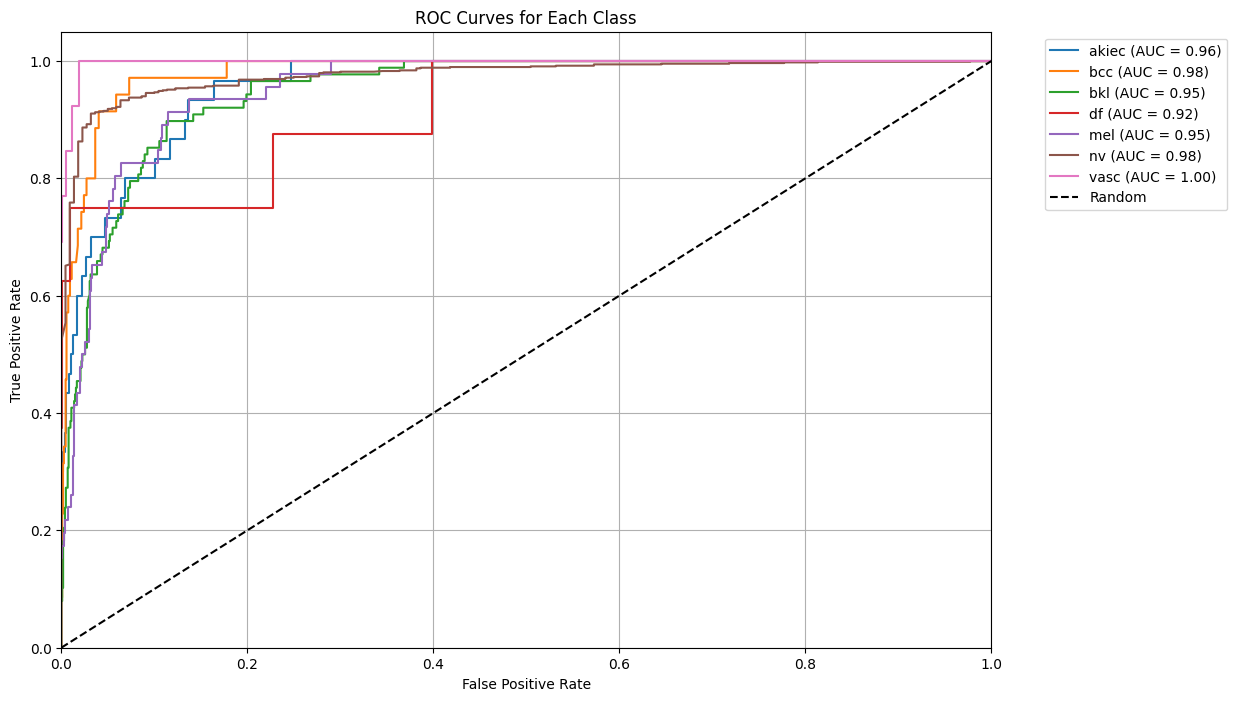

In [23]:
predictions = tl_model.predict(test_image_gen, verbose=1)
class_names = list(test_image_gen.class_indices.keys())

fig, auc_scores = plot_roc_curves_from_generator(
    predictions,
    test_image_gen.classes,
    class_names
)

print("\nAUC Scores per class:")
for class_name, score in auc_scores.items():
    print(f'{class_name}: {score:.3f}')

plt.figure()
plt.savefig('roc_curves.png', bbox_inches='tight', dpi=300)
plt.close()

In [24]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step


Normalized confusion matrix
[[0.46666667 0.16666667 0.13333333 0.         0.13333333 0.1
  0.        ]
 [0.11428571 0.65714286 0.11428571 0.         0.         0.05714286
  0.05714286]
 [0.04545455 0.04545455 0.45454545 0.01136364 0.19318182 0.23863636
  0.01136364]
 [0.         0.125      0.         0.25       0.125      0.5
  0.        ]
 [0.04347826 0.         0.04347826 0.         0.63043478 0.2826087
  0.        ]
 [0.0011325  0.00453001 0.01019253 0.         0.01472254 0.96828992
  0.0011325 ]
 [0.         0.         0.         0.         0.         0.23076923
  0.76923077]]


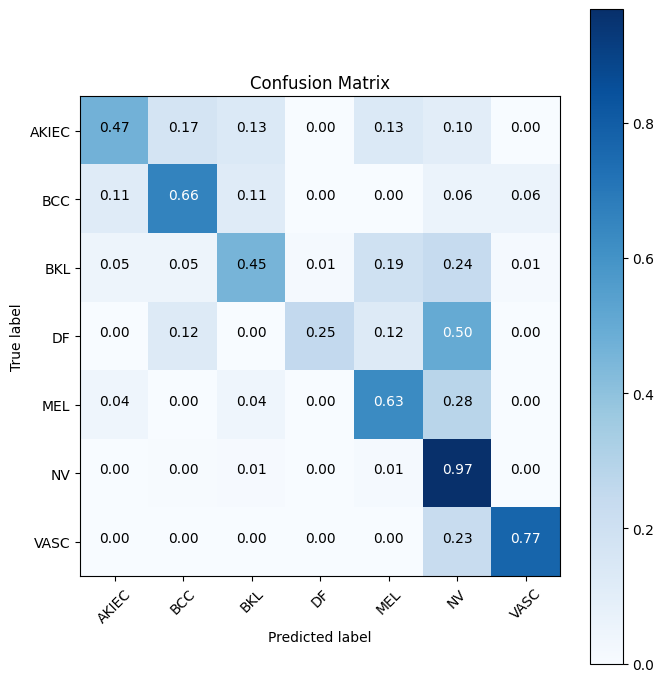

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [26]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.975521,0.976428,0.939257,0.993654,0.952856,0.932910,0.993654,0.966326
f1,0.509091,0.638889,0.544218,0.363636,0.527273,0.958520,0.740741,0.882140
false_discovery_rate,0.440000,0.378378,0.322034,0.333333,0.546875,0.051054,0.285714,0.117860
false_negative_rate,0.533333,0.342857,0.545455,0.750000,0.369565,0.031710,0.230769,0.117860
false_positive_rate,0.010252,0.013109,0.018719,0.000913,0.033113,0.209091,0.003670,0.019643
negative_predictive_value,0.985158,0.988743,0.954023,0.994545,0.983638,0.861386,0.997245,0.980357
positive_predictive_value,0.560000,0.621622,0.677966,0.666667,0.453125,0.948946,0.714286,0.882140
precision,0.560000,0.621622,0.677966,0.666667,0.453125,0.948946,0.714286,0.882140
recall,0.466667,0.657143,0.454545,0.250000,0.630435,0.968290,0.769231,0.882140
sensitivity,0.466667,0.657143,0.454545,0.250000,0.630435,0.968290,0.769231,0.882140


# Best Model Based on Validation Loss

In [27]:
tl_model.load_weights('val_loss_epoch.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [28]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - categorical_accuracy: 0.7810 - f1_score: 0.7852 - loss: 1.3923 - precision: 0.7895 - recall: 0.7811 - top_2_accuracy: 0.8980 - top_3_accuracy: 0.9461
val_loss: 0.7961767911911011
val_cat_acc: 0.8833522200584412
val_top_2_acc: 0.9513023495674133
val_top_3_acc: 0.9750849604606628
val_precision: 0.8875622153282166
val_recall: 0.8839067220687866
val_f1_score 0.8857049942016602


In [29]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [30]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - categorical_accuracy: 0.7817 - f1_score: 0.7865 - loss: 1.3822 - precision: 0.7915 - recall: 0.7816 - top_2_accuracy: 0.9106 - top_3_accuracy: 0.9555
test_loss: 0.8005609512329102
test_cat_acc: 0.8812329769134521
test_top_2_acc: 0.9546690583229065
test_top_3_acc: 0.9800543785095215
test_precision: 0.8860713243484497
test_recall: 0.8806134462356567
test_f1_score 0.8832888007164001


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step

AUC Scores per class:
akiec: 0.943
bcc: 0.983
bkl: 0.950
df: 0.914
mel: 0.950
nv: 0.976
vasc: 0.999


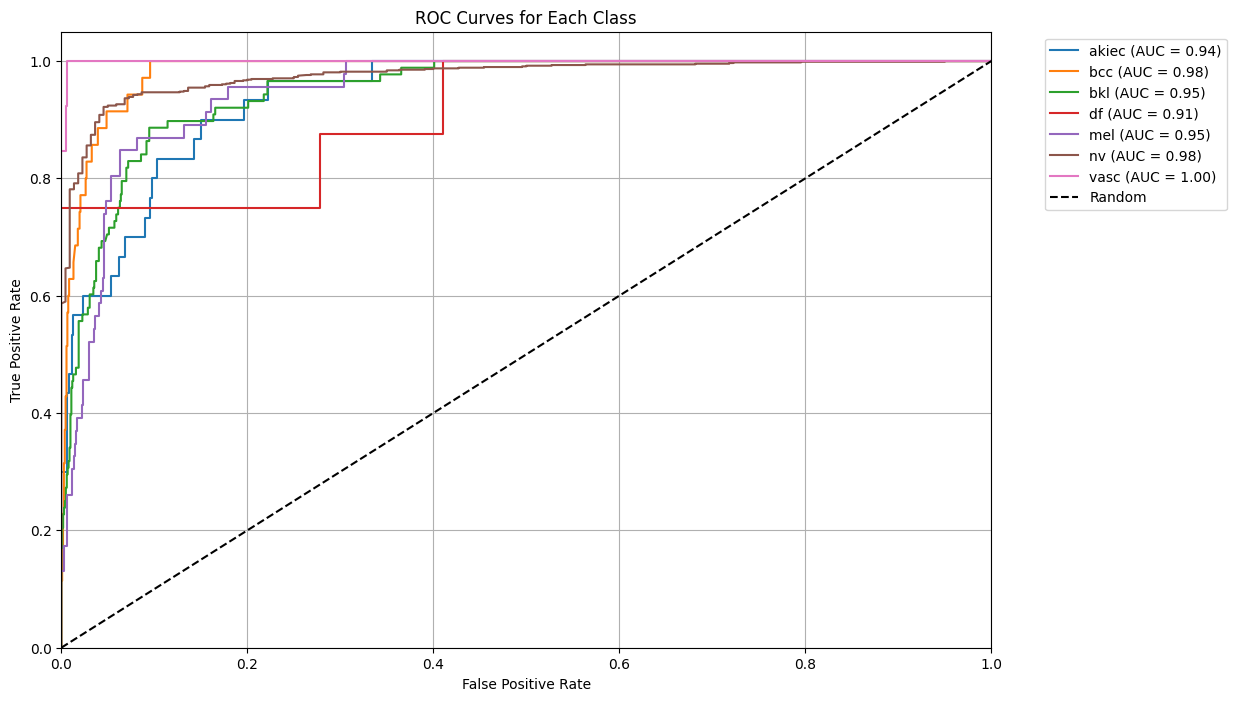

In [31]:
predictions = tl_model.predict(test_image_gen, verbose=1)
class_names = list(test_image_gen.class_indices.keys())

fig, auc_scores = plot_roc_curves_from_generator(
    predictions,
    test_image_gen.classes,
    class_names
)

print("\nAUC Scores per class:")
for class_name, score in auc_scores.items():
    print(f'{class_name}: {score:.3f}')

plt.figure()
plt.savefig('roc_curves_valloss.png', bbox_inches='tight', dpi=300)
plt.close()

In [32]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


Normalized confusion matrix
[[0.43333333 0.1        0.2        0.         0.13333333 0.13333333
  0.        ]
 [0.08571429 0.62857143 0.17142857 0.         0.         0.08571429
  0.02857143]
 [0.03409091 0.03409091 0.60227273 0.         0.14772727 0.17045455
  0.01136364]
 [0.         0.125      0.         0.625      0.125      0.125
  0.        ]
 [0.06521739 0.04347826 0.13043478 0.         0.52173913 0.23913043
  0.        ]
 [0.         0.00339751 0.01698754 0.         0.02151755 0.95583239
  0.00226501]
 [0.         0.         0.         0.         0.         0.15384615
  0.84615385]]


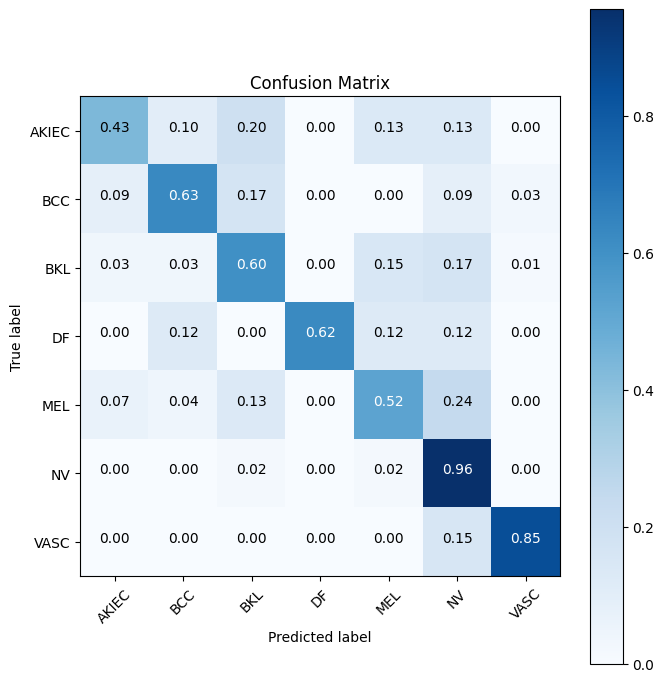

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix_valloss.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [34]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.976428,0.977335,0.938350,0.997280,0.946510,0.932004,0.994560,0.966067
f1,0.500000,0.637681,0.609195,0.769231,0.448598,0.957459,0.785714,0.881233
false_discovery_rate,0.409091,0.352941,0.383721,0.000000,0.606557,0.040909,0.266667,0.118767
false_negative_rate,0.566667,0.371429,0.397727,0.375000,0.478261,0.044168,0.153846,0.118767
false_positive_rate,0.008388,0.011236,0.032512,0.000000,0.035005,0.163636,0.003670,0.019794
negative_predictive_value,0.984274,0.987839,0.965585,0.997268,0.978887,0.825112,0.998162,0.980206
positive_predictive_value,0.590909,0.647059,0.616279,1.000000,0.393443,0.959091,0.733333,0.881233
precision,0.590909,0.647059,0.616279,1.000000,0.393443,0.959091,0.733333,0.881233
recall,0.433333,0.628571,0.602273,0.625000,0.521739,0.955832,0.846154,0.881233
sensitivity,0.433333,0.628571,0.602273,0.625000,0.521739,0.955832,0.846154,0.881233
